## Evaluation of minibatch-updates

Can we use updates for documents scoring

Evaluation strategy based on political mashup data

- [ ] Get snippets for the word democracy by political party (Labour/Conservative)
- [ ] Divide in train/test set
- [ ] Get existing model, update with examples from training set, 
- [ ] Check how consistent updates increase left or rightwing bias. How? One strategy is to update model with all Labour examples, then for each Labour document the updates should be smaller than for the Conservative ones?

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2
%matplotlib inline
import gensim.downloader as api
from gensim.models.word2vec import Word2Vec
from tqdm import tqdm_notebook
import pandas as pd
import re
import sys
sys.path.append('../')
from utils import *

In [4]:
def cleanhtml(raw_html):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', raw_html)
    return cleantext

num_tokens = lambda x: len(x.split())

In [5]:
df = pd.read_csv('democracy_hits.csv',escapechar='\\')

In [6]:
df['text'] = df['highlight text'].apply(cleanhtml)

In [7]:
df['length'] = df['text'].apply(num_tokens)

In [8]:
df.head()

,id,index,type,score,date,speaker,party,function,role,paragraphs_count,house,highlight text,text,length
0,uk.proc.d.1988-07-27.12.1.67,uk.proc,speech,1.245629,1988-07-27,Mr. Flannery,Labour,NaN,mp,2,commons,I am about to finish so that another hon. Memb...,I am about to finish so that another hon. Memb...,58
1,uk.proc.d.1987-11-03.8.1.108,uk.proc,speech,1.150663,1987-11-03,Mr. Leigh,Conservative,NaN,mp,1,commons,<em>Democracy</em>.,Democracy.,1
2,uk.proc.d.1961-04-24.17.1.30,uk.proc,speech,1.150663,1961-04-24,Mr. A. Fenner Brockway,Labour,NaN,mp,1,commons,<em>Democracy</em>.,Democracy.,1
3,uk.proc.d.1978-12-06.7.1.30,uk.proc,speech,1.089925,1978-12-06,Mr. Thorne,Labour,NaN,mp,2,commons,We have a <em>democracy</em> in the United Kin...,We have a democracy in the United Kingdom with...,67
4,uk.proc.d.1970-12-03.14.1.214,uk.proc,speech,1.078746,1970-12-03,Mr. Ogden,Labour,NaN,mp,2,commons,"No, I will not give way. The hon. Member for H...","No, I will not give way. The hon. Member for H...",27


In [9]:
dayParty = df.groupby(['date','party']).agg({'text': ' '.join, 'length': sum})

In [10]:
dayParty = dayParty.sample(frac=1)
dayParty.head()

,,text,length
date,party,,
1971-02-17,Labour,elected to uphold parliamentary democracy and...,49
1991-06-18,Labour,"I apologise, Mr. Deputy Speaker. The Governmen...",182
1990-01-19,Conservative,pace or the democratisation of Hong Kong's Le...,114
1990-03-20,Labour,fortunate enough to have raised a couple of A...,60
1983-07-18,Labour,undemocratic tactics to ensure that DLOs cann...,56


In [11]:
dayParty['id'] = '' 
dayParty['processed_text'] = dayParty['text'].apply(preprocess_sent)
dayParty['processed_text'] =  dayParty['processed_text'].apply(lambda x : x[0])
dayParty = dayParty.reset_index()

In [12]:
train,test = dayParty.iloc[:int(dayParty.shape[0]*.5)],dayParty.iloc[int(dayParty.shape[0]*.5):]

In [13]:
print(train.shape,test.shape)

(4329, 6) (481, 6)


In [14]:
test.party.value_counts()

Labour                   265
Conservative             215
Scottish Labour Party      1
Name: party, dtype: int64

2477

In [14]:
#import logging
#logging.basicConfig(format='%(levelname)s : %(message)s', level=logging.INFO)
#logging.root.level = logging.INFO  # ipython sometimes messes up the logging setup; restore

In [17]:
for party in ["Labour","Conservative"]:
    batch = list(train[train.party==party]['processed_text'])
    model = Word2Vec.load("../../../../../LivingwithMachines/Lab2/all_books/w2v_003/w2v_words.model") 
    model.train(batch,total_examples=len(batch),epochs=4)
    model.save(f'../../../Processed/Models/evaluation/w2v_words_updated_{party}.model')

#orig_model = Word2Vec.load("../../../../../LivingwithMachines/Lab2/all_books/w2v_003/w2v_words.model") 

In [26]:
batch = list(train['processed_text'])
model = Word2Vec.load("../../../../../LivingwithMachines/Lab2/all_books/w2v_003/w2v_words.model") 
model.train(batch,total_examples=len(batch),epochs=4)
model.save('../../../Processed/Models/evaluation/w2v_words_updated_All.model')

In [27]:
lab_model = Word2Vec.load('../../../Processed/Models/evaluation/w2v_words_updated_Labour.model')
con_model = Word2Vec.load('../../../Processed/Models/evaluation/w2v_words_updated_Conservative.model')
all_model = Word2Vec.load('../../../Processed/Models/evaluation/w2v_words_updated_All.model')

In [28]:
diff = {}
for w in tqdm_notebook(lab_model.wv.vocab):
    diff[w] = (1 - cosine(lab_model.wv[w],con_model.wv[w]),1 - cosine(lab_model.wv[w],all_model.wv[w]))

In [30]:
diff['indeed']

(0.5763755440711975, 0.8090708255767822)

In [24]:
sorted(diff.items(),key = lambda x: x[1], reverse=False)[:100]

[('indeed', 0.5763755440711975),
 ('however', 0.5795308947563171),
 ('also', 0.5819544196128845),
 ('then', 0.5834676027297974),
 ('even', 0.5884152054786682),
 ('perhaps', 0.5958497524261475),
 ('s', 0.6144764423370361),
 ('just', 0.6262642741203308),
 ('labour', 0.6308382153511047),
 ('here', 0.6371561288833618),
 ('know', 0.6375672221183777),
 ('conservative', 0.6386924982070923),
 ('today', 0.6390063166618347),
 ('now', 0.6415405869483948),
 ('community', 0.6431410312652588),
 ('think', 0.6447187066078186),
 ('yet', 0.6484003067016602),
 ('them', 0.6489109396934509),
 ('him', 0.6510211229324341),
 ('such', 0.6511513590812683),
 ('democratic', 0.6544830203056335),
 ('she', 0.6556092500686646),
 ('british', 0.6575725078582764),
 ('may', 0.6593016386032104),
 ('because', 0.6595911383628845),
 ('day', 0.6598412394523621),
 ('when', 0.6604326963424683),
 ('state', 0.6661936044692993),
 ('although', 0.6668485403060913),
 ('fact', 0.6683617234230042),
 ('authority', 0.6690003275871277),
 

In [ ]:
output = []
for party in ["Labour","Conservative"]:
    for batch in tqdm_notebook(test[test.party==party]['processed_text'][:50]):
        model = Word2Vec.load('../../../Processed/Models/evaluation/w2v_words_updated_lab.model')
        model.train([batch],total_examples=len([batch]),epochs=4)
        output.append([party,model.wv.vectors,model.wv['democracy']])
        

In [17]:
model = Word2Vec.load('../../../Processed/Models/evaluation/w2v_words_updated_lab.model')
orig_vec = model.wv['democracy']

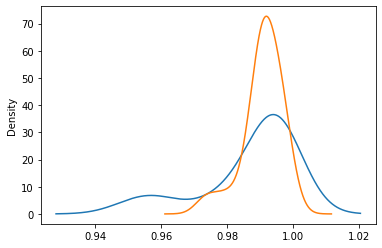

In [18]:
from scipy.spatial.distance import cosine
lab,con = [],[]
for p,m,v in output:
    if p == 'Labour':
        lab.append(1 - cosine(orig_vec,v))
    else:
        con.append(1 - cosine(orig_vec,v))

pd.Series(lab).plot(kind='density')
pd.Series(con).plot(kind='density')